In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_decision_forests as tfdf

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [2]:
def decide_chore_id( data, streams ):
    #print(streams['description'])
    #if 'GPU' in fullstring
    #print(streams.head())
    gpu_list = []
    for index, row in streams.iterrows():
        if('GPU' in row['description']):
            #print(row['description'])
            #print(row['stream_id'])
            gpu_list.append(int(row['stream_id']))
            #print(gpu_list)
            
    for index, row in data.iterrows():
        #if gpu.count(data['streams']) > 0:
        if int(row['stream_id']) in gpu_list:
            row['chore_id'] = 1
        else:
            row['chore_id'] = 0
                

In [3]:
path = './traces/'# use your path
#all_files = glob.glob(path + "/*.h5")
all_files = glob.glob(path + "/demo_new*.prof.h5")

li = []

for filename in all_files:
    trace =  pd.HDFStore(filename)
    data = trace.get('/events')
    streams = trace.get('/streams')
    
    #print(type(streams))
    #print(type(data))
    
    #print(streams)
    #print(data)

    #print('*****************************')
    
    
    decide_chore_id(data, streams)
    trace.close()
    
    li.append(data)

df = pd.concat(li, axis=0, ignore_index=True)


In [5]:
df.head()

,tid,node_id,tcid,dst,src,flags,id,stream_id,taskpool_id,msg_size,...,dc_id,m,loc_B,dc_dataid,k,loc_C,n,size,dc_key,trc
0,0,0,1,1,0,1,0,3,-1,120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48,0,1,1,0,1,0,3,-1,120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,1,1,0,1,0,3,-1,5120000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,48,0,1,1,0,1,0,3,-1,5120000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24,0,1,1,0,1,0,3,-1,120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clean the data

In [6]:
#remove info from other traces
df_refined = df[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df_refined['exec_time'] = (df['end'] - df['begin']) * .001 #0.001 nano seconds to micro seconds
#df_refined = df_refined.astype(float)

In [7]:
df_refined['chore_id'].unique()

array([0, 1], dtype=object)

In [8]:
df_refined = df_refined.astype(float)

In [9]:
df_refined['chore_id'].unique()

array([0., 1.])

In [10]:
df_class_name = {0: 'dpotrf', 1: 'dtrsm', 2: 'dsyrk', 3: 'dgemm'}

In [13]:
filter = ( (df_refined['task_class_id'] >= 0 ) & ( df_refined['task_class_id'] <= 3 ) & ( df_refined['priority'] >= 0 ) )
#remove all other classes other than dpotrf, dgemm, trsm and syrk
df_refined = df_refined[filter]
df_refined.head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
600,142504.0,6353839.0,2.0,1.0,0.0,2.0,5120000.0,0.0,6211.335
601,6365813.0,12324486.0,2.0,1.0,0.0,2.0,5120000.0,0.0,5958.673
602,12328024.0,18154320.0,2.0,1.0,0.0,2.0,5120000.0,0.0,5826.296
603,18157943.0,23989863.0,2.0,1.0,0.0,2.0,5120000.0,0.0,5831.920
604,23994606.0,29760578.0,2.0,1.0,0.0,2.0,5120000.0,0.0,5765.972


In [14]:
df_refined['chore_id'].unique()

array([0.])

In [61]:
df_refined['chore_id'].unique()

array([0.])

In [62]:
df_class = {}
for i in df_refined['task_class_id'].unique():
    df_class[i] = df_refined[df_refined['task_class_id'] == i]
    

### remove outliers

In [63]:

df_class_new = {}
for i in df_refined['task_class_id'].unique():
    title = df_class_name[i]
    Q1 = df_class[i]['exec_time'].quantile(0.25)
    Q3 = df_class[i]['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_class[i]['exec_time'] >= Q1 - 1.5 * IQR) & (df_class[i]['exec_time'] <= Q3 + 1.5 *IQR)
    df_class_new[i] = df_class[i].loc[filter]
    df_class_new[i] = df_class_new[i].astype(float)
    #plt.figure()
    #sns.displot(df_new, x="exec_time", hue='total_data_size', binwidth=5e2)
    #plt.title(title)
#plt.show()


## integrate likelihood of the data being in cash.
we assume that all the task whose execution time is in the first quartile could have had all its data in the cache. While, the rest of the tasks would have resulted in a cache flush. While predicting we assume that the that the data of the task is not in the cache 

In [64]:

for i in df_refined['task_class_id'].unique():
    Q1 = df_class_new[i]['exec_time'].quantile(0.25)
    Q3 = df_class_new[i]['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    df_class_new[i]['cache_likelihood'] = np.where(df_class_new[i]['exec_time'] < Q1, 1, 0)

In [65]:
df_class_new[3].tail()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time,cache_likelihood
13534,8.510936e+10,8.523962e+10,4.0,3.0,0.0,3.0,15360000.0,49.0,130261.962,0
13535,8.523965e+10,8.536988e+10,4.0,3.0,0.0,3.0,15360000.0,43.0,130234.336,0
13536,8.536995e+10,8.550032e+10,4.0,3.0,0.0,3.0,15360000.0,37.0,130375.590,0
13537,8.550051e+10,8.563984e+10,4.0,3.0,0.0,3.0,15360000.0,31.0,139329.509,0
13542,8.626220e+10,8.639252e+10,4.0,3.0,0.0,3.0,15360000.0,43.0,130322.776,0


In [66]:
df_class_new[3][df_class_new[3]['cache_likelihood'] == 1]#.total_data_siz

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time,cache_likelihood
710,3.457715e+09,3.457715e+09,4.0,3.0,0.0,3.0,15360000.0,9531.0,0.523,1
713,3.458183e+09,3.458184e+09,4.0,3.0,0.0,3.0,15360000.0,6198.0,0.678,1
714,3.458594e+09,3.458595e+09,4.0,3.0,0.0,3.0,15360000.0,5627.0,0.548,1
715,3.458598e+09,3.458599e+09,4.0,3.0,0.0,3.0,15360000.0,5381.0,0.410,1
717,3.459057e+09,3.459057e+09,4.0,3.0,0.0,3.0,15360000.0,7363.0,0.509,1
...,...,...,...,...,...,...,...,...,...,...
6801,4.985896e+09,4.985897e+09,4.0,3.0,0.0,3.0,15360000.0,237.0,0.535,1
6802,4.985898e+09,4.985899e+09,4.0,3.0,0.0,3.0,15360000.0,171.0,0.615,1
6803,4.985900e+09,4.985901e+09,4.0,3.0,0.0,3.0,15360000.0,129.0,0.459,1
6822,5.960795e+09,5.960796e+09,4.0,3.0,0.0,3.0,15360000.0,37.0,0.576,1


## combine all the class into a single dataframe

In [67]:
frames = []
df_refined_new = pd.DataFrame()
for i in df_refined['task_class_id'].unique():
    frames.append(df_class_new[i])
df_refined_new = pd.concat(frames) 

In [68]:
df_refined_new.head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time,cache_likelihood
600,142504.0,6353839.0,2.0,1.0,0.0,2.0,5120000.0,0.0,6211.335,0
601,6365813.0,12324486.0,2.0,1.0,0.0,2.0,5120000.0,0.0,5958.673,0
602,12328024.0,18154320.0,2.0,1.0,0.0,2.0,5120000.0,0.0,5826.296,0
603,18157943.0,23989863.0,2.0,1.0,0.0,2.0,5120000.0,0.0,5831.920,0
604,23994606.0,29760578.0,2.0,1.0,0.0,2.0,5120000.0,0.0,5765.972,0


In [69]:
df_refined_new.tail()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time,cache_likelihood
12921,1.168562e+10,1.170984e+10,4.0,0.0,0.0,1.0,5120000.0,2744.0,24218.900,0
13113,3.382986e+10,3.385407e+10,4.0,0.0,0.0,1.0,5120000.0,1000.0,24214.095,0
13274,5.355593e+10,5.358016e+10,4.0,0.0,0.0,1.0,5120000.0,512.0,24229.742,0
13421,7.187625e+10,7.190062e+10,4.0,0.0,0.0,1.0,5120000.0,216.0,24361.378,0
13546,8.811960e+10,8.814387e+10,4.0,0.0,0.0,1.0,5120000.0,8.0,24271.052,0


## change some columns to catogrical data

In [70]:
#df_refined_new = pd.get_dummies(df_refined_new, prefix='task_pool_', columns=['taskpool_id'], prefix_sep='')
df_refined_new = pd.get_dummies(df_refined_new, prefix='task_class_', columns=['task_class_id'], prefix_sep='')
df_refined_new = pd.get_dummies(df_refined_new, prefix='chore_', columns=['chore_id'], prefix_sep='')

In [71]:
df_refined_new.head()

,begin,end,taskpool_id,nb_data_items,total_data_size,priority,exec_time,cache_likelihood,task_class_0.0,task_class_1.0,task_class_2.0,task_class_3.0,chore_0.0
600,142504.0,6353839.0,2.0,2.0,5120000.0,0.0,6211.335,0,0,1,0,0,1
601,6365813.0,12324486.0,2.0,2.0,5120000.0,0.0,5958.673,0,0,1,0,0,1
602,12328024.0,18154320.0,2.0,2.0,5120000.0,0.0,5826.296,0,0,1,0,0,1
603,18157943.0,23989863.0,2.0,2.0,5120000.0,0.0,5831.920,0,0,1,0,0,1
604,23994606.0,29760578.0,2.0,2.0,5120000.0,0.0,5765.972,0,0,1,0,0,1


### Divide the data to training and test sets (GEMM)

In [72]:
train_dataset = df_refined_new.sample(frac=0.8, random_state=0)
test_dataset = df_refined_new.drop(train_dataset.index)
print(train_dataset.shape)
print(test_dataset.shape)

(2562, 13)
(640, 13)


## Divide the data into trainig features and labels

In [73]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('exec_time')
test_labels = test_features.pop('exec_time')

In [74]:
train_features.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
begin,2562.0,3.914588e+10,2.744013e+10,147303.0,1.419773e+10,3.791576e+10,6.293398e+10,8.849497e+10
end,2562.0,3.925326e+10,2.745720e+10,7831356.0,1.432783e+10,3.801704e+10,6.306416e+10,8.851914e+10
taskpool_id,2562.0,3.801717e+00,5.978200e-01,2.0,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
chore_id,2562.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
nb_data_items,2562.0,2.703357e+00,4.736522e-01,1.0,2.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
total_data_size,2562.0,1.333358e+07,3.446834e+06,5120000.0,1.024000e+07,1.536000e+07,1.536000e+07,1.536000e+07
priority,2562.0,1.248985e+03,1.788541e+03,0.0,2.120000e+02,6.435000e+02,1.466750e+03,1.396800e+04
cache_likelihood,2562.0,2.494145e-01,4.327586e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
task_class_0.0,2562.0,7.806401e-03,8.802548e-02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
task_class_1.0,2562.0,1.924278e-01,3.942842e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


# -------------------Build the multi variate full model------------------------------

## select the required features from the list

In [97]:
## for the time being select only total_data_size, priority, diff task_classes and diff taskpools

#train_features = train_features.drop('end', 1)
#train_features = train_features.drop('end', 1)
train_features = train_features.drop(['chore_id', 'begin', 'end', 'taskpool_id'], axis = 1)
test_features = test_features.drop(['chore_id', 'begin', 'end', 'taskpool_id'], axis = 1)



KeyError: "['chore_id', 'begin', 'end', 'taskpool_id'] not found in axis"

In [98]:
train_features.head()

,nb_data_items,total_data_size,priority,cache_likelihood,task_class_0.0,task_class_1.0,task_class_2.0,task_class_3.0
3741,2.0,10240000.0,7489.0,0,0,1,0,0
1857,3.0,15360000.0,842.0,0,0,0,0,1
3691,2.0,5120000.0,0.0,0,0,1,0,0
3932,2.0,10240000.0,1451.0,0,0,1,0,0
2982,3.0,15360000.0,128.0,0,0,0,0,1


In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer = layers.Normalization(input_shape=[1,], axis=None)
normalizer.adapt(np.array(train_features))

In [ ]:


full_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [ ]:
full_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mse', metrics=[tf.keras.metrics.Accuracy()])
print(full_model.metrics_names)

## Train the model

In [ ]:
history = full_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [total_data_size]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [77]:
full_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 26
Trainable params: 9
Non-trainable params: 17
_________________________________________________________________


In [78]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
95,1.287805e+10,0.0,1.316332e+10,0.0,95
96,1.287479e+10,0.0,1.316002e+10,0.0,96
97,1.287157e+10,0.0,1.315664e+10,0.0,97
98,1.286833e+10,0.0,1.315329e+10,0.0,98
99,1.286509e+10,0.0,1.314995e+10,0.0,99


## Test the Model 

In [79]:
#test_results = {}
#test_results['full_model'] = full_model.evaluate(
#    test_features, test_labels, verbose=0)
#loss, acc = full_model.evaluate(test_features, test_labels, verbose=2)
#print(test_results['full_model'])

loss = full_model.evaluate(test_features, test_labels, batch_size=128)
print(loss)

5/5 [==============================] - 0s 6ms/step - loss: 13167913984.0000 - accuracy: 0.0000e+00
[13167913984.0, 0.0]


In [83]:

print(full_model.predict([3, 15360000.0, 9663.0, 0,  0, 0, 0, 1]))
print(df_class_new[i]['exec_time'].min())
print(df_class_new[i]['exec_time'].max())

[[2819.053]]
24168.378
24786.363


## Train using DNN

In [84]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [85]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 8)                17        
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                576       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
_________________________________________________________________


In [86]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

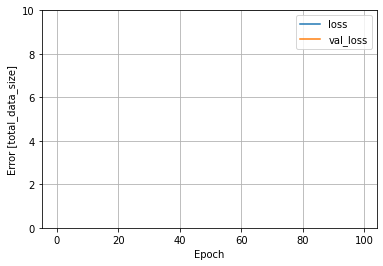

In [87]:
plot_loss(history)

In [88]:

print(dnn_model.predict([3, 15360000.0, 9663.0, 0,  0, 0, 0, 1]))
print(test_labels.min())
print(test_labels.max())

[[132892.98]]
6335.5830000000005
138949.75


In [89]:

print(dnn_model.predict([3, 15360000.0, 9663.0, 1,  0, 0, 0, 1]))
print(test_labels.min())
print(test_labels.max())

[[132132.39]]
6335.5830000000005
138949.75


## Predict from a different trace

In [93]:
path = './traces/'# use your path
#all_files = glob.glob(path + "/*.h5")
all_files = glob.glob(path + "/demo_test-*.prof.h5")

li = []

for filename in all_files:
    trace =  pd.HDFStore(filename)
    data = trace.get('/events')
    trace.close()
    
    li.append(data)

df_diff = pd.concat(li, axis=0, ignore_index=True)

In [117]:
df_diff_refined = df_diff[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df_diff_refined['exec_time'] = (df['end'] - df['begin']) * .001 #0.001 nano seconds to micro seconds
df_diff_refined = df_diff_refined.astype(float)

filter = ( (df_diff_refined['task_class_id'] >= 0 ) & ( df_diff_refined['task_class_id'] <= 3 ) & ( df_diff_refined['priority'] >= 0 ) )
#remove all other classes other than dpotrf, dgemm, trsm and syrk
df_diff_refined = df_diff_refined[filter]
df_diff_refined.head()
df_diff_refined = df_diff_refined.dropna()

In [118]:
print(dnn_model.predict([2, # nb_data_items
                         2000000.0, #total_data_size  
                         0, #priority
                         1, #cache_likelihood
                         #task_class_0.0 task_class_1.0 task_class_2.0 task_class_3.0
                         0, 1, 0, 0]))

[[812.987]]


In [119]:
print(dnn_model.predict([2, # nb_data_items
                         2000000.0, #total_data_size  
                         0, #priority
                         0, #cache_likelihood
                         #task_class_0.0 task_class_1.0 task_class_2.0 task_class_3.0
                         0, 1, 0, 0]))

[[16629.34]]


In [121]:
df_diff_class_1 = df_diff_refined[df_diff_refined['task_class_id'] == 1]
print(df_diff_class_1['exec_time'].min())
print(df_diff_class_1['exec_time'].max())
print(sum(df_diff_class_1['exec_time']) / len(df_diff_class_1['exec_time']))

1.928
149259.303
102656.5046090426


## Train using random forest

In [90]:
# Convert the dataset into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_features, label="my_label")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_features, label="my_label")

NameError: name 'tfdf' is not defined